# Importing the libararies

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For data cleaning
import string
import spacy
import pycountry

# from sklearn.decomposition import PCA

# For data cleaning and creating word embeddings
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import gensim
# from gensim.models import Word2Vec
# from gensim.utils import simple_preprocess
#

# Grouping multiple datasets

In [2]:
# Let's load the train and test csv files from Kaggle folder and tsv files from the LIAR folder
kaggle_data = pd.read_csv('Datasets used/Kaggle dataset/train.csv')


# Let's load the train and test tsv files from LIAR folder
liar_test = pd.read_csv('Datasets used/LIAR dataset/test.tsv', delimiter='\t')
liar_train = pd.read_csv('Datasets used/LIAR dataset/train.tsv', delimiter='\t')
previous_data = pd.read_excel('Datasets used/Fake news challenge/Data.xlsx')
previous_data.columns = ['title','label']

In [3]:
# Extracting title and labels
kaggle_data = kaggle_data[['title','label']]

liar_train = liar_train[['Says the Annies List political group supports third-trimester abortions on demand.','false']]
liar_train.columns = ['title','label']

liar_test = liar_test[['Building a wall on the U.S.-Mexico border will take literally years.','true']]
liar_test.columns = ['title','label']

In [4]:
# Extracting only extreme labels
liar_train = liar_train[(liar_train['label'] == 'false') | (liar_train['label'] == 'true') | (liar_train['label'] == 'pants-fire')]
liar_test = liar_test[(liar_test['label'] == 'false') | (liar_test['label'] == 'true') | (liar_test['label'] == 'pants-fire')]

In [5]:
# Replacing pants fire with false=
liar_train['label'] = liar_train['label'].replace({'pants-fire':'false'})
liar_test['label'] = liar_test['label'].replace({'pants-fire':'false'})

In [6]:
# Combining all the datasets 
df = pd.concat([kaggle_data,liar_train,liar_test,previous_data],axis=0)

# Dropping any duplicates
df.drop_duplicates(inplace=True)

In [7]:
# Storing the file 
df.to_excel('Data.xlsx', index=False)

# Exploratory data analysis

In [4]:
# Let's load the combined dataset
df = pd.read_excel('Data.xlsx')

In [5]:
# Checking the shape of the dataframe
df.shape

(46696, 2)

In [6]:
# Checking first 5 rows of the dataframe
df.head(5)

,title,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


Since we have combined multiple datasets thus in every dataset the names of labels could be different.

In [7]:
# Replacing 1 with true and 0 with false
df['label'] = df['label'].replace({1: 'true', 0: 'false'})

In [8]:
# Let's check the datatype of the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46696 entries, 0 to 46695
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   46695 non-null  object
 1   label   46696 non-null  object
dtypes: object(2)
memory usage: 729.8+ KB


In [9]:
# Checking any null values
df.isnull().mean()*100

title    0.002142
label    0.000000
dtype: float64

In [10]:
# Checking any duplicated values
df.duplicated().sum()

0

<AxesSubplot:ylabel='label'>

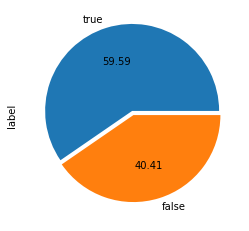

In [11]:
# Let's check distribution of data across both classes in the target variable
ex = (0.05, 0)
df['label'].value_counts().plot(kind='pie',autopct='%.2f',explode= ex)

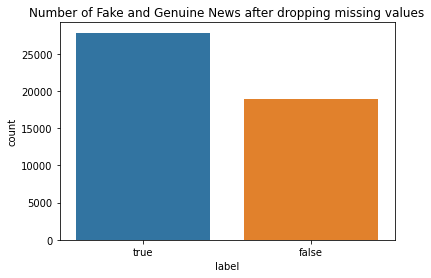

In [15]:
# Visualize the target's distribution
sns.countplot(x='label', data=df)
plt.title("Number of Fake and Genuine News after dropping missing values")
plt.show()

# Data cleaning 

- Removal of punctuations
- Tokenization
- Lowercasing excluding country names
- Stop word removal
- Spelling check
- Stemming/lemmatization



The main difference between POS tagging and NER is that POS tags are attached to single words, while NER tags can be attached to multiple words [1]. Additionally, POS tagging is focused on identifying the part of speech of a single word, while NER is focused on identifying entities within the text, such as people, places, organizations, and events. NER also involves not only detecting the type of Named Entity [1], but also segmenting the entity from the text.

In [12]:
# Since title have some null values in it so we will simply remove them
df.dropna(inplace=True)

In [13]:
# Function for removing punctuations
def remove_punctuation(text):
    no_punct = [word for word in text if word not in string.punctuation]
    no_punct = ''.join(no_punct)
    return no_punct

# Let's apply function on the title feature to remove the punctuations
df['title'] = df['title'].apply(lambda x: remove_punctuation(x))

In [33]:
# Create a set of country names
countries = set([country.name for country in pycountry.countries])

# Define the function to lowercase words, excluding country names
def lower(text):
    words = text.split()
    lowercase_words = [word.lower() if word not in countries else word for word in words]
    return ' '.join(lowercase_words)

# Let's apply the function on title feature to lower case
df['title'] = df['title'].apply(lower)

In [43]:
# Load the English language model in Spacy
nlp = spacy.load("en_core_web_sm")

# Function for removing stop words
def remove_stopwords(text):
    
    doc = nlp(text) # Processing the text using Spacy
    filtered_doc = [word.text for word in doc if not word.is_stop] # Remove stop words from the processed document
    return ' '.join(filtered_doc)

# Let's apply the function on title feature to remove stop words
df['title'] = df['title'].apply(remove_stopwords)

In [44]:
df.head(4)

,title,label
0,house dem aide comey letter jason chaffetz twe...,true
1,flynn hillary clinton big woman campus breitbart,false
2,truth fired,true
3,15 civilians killed single airstrike identified,true


Since title is a feature having long sentences in it, thus the imputation techniques will be little modified.

1. Fill missing values with a placeholder: One simple approach is to fill the missing values with a placeholder such as NA or missing. This approach can be useful if you want to retain the structure of the original text data and still be able to identify the missing values. However, it's important to ensure that the placeholder does not occur naturally in the text data.

2. Impute missing values using statistical techniques: You can use statistical techniques such as mean or mode imputation to fill in missing values. For example, you could compute the average length of the sentences in the feature and use this value to fill in the missing values.

3. Impute missing values using machine learning models: You can use machine learning models such as regression or clustering to impute missing values based on the patterns in the other features. For example, you could train a regression model to predict the length of the sentences in the feature based on the values in other features, and then use this model to impute missing values.

4. Use natural language processing techniques: You can use natural language processing techniques such as language models or topic models to impute missing values based on the context of the text data. For example, you could use a language model to generate plausible sentences that fit the context of the text data and use these sentences to fill in the missing values.

In [12]:
# let's crete an object of WordNetLemmatizer class for doing lemmatization
lemm = WordNetLemmatizer()

# Empty list to store the clean title
cleaned_data = []
for i in df['title']:
    cleaned_title = re.sub('[^a-zA-Z]',' ',str(i)) # Removal of punctuations
    cleaned_title = cleaned_title.split() # Tokenization
    
    # create a set of country names using the pycountry library
    countries = set([country.name.lower() for country in pycountry.countries])
    
    cleaned_title = [word.lower() if word.lower() not in countries else word for word in cleaned_title] # lowering the words except country names
    
    # Stopword removal and lemmatizatoin
    cleaned_title = [lemm.lemmatize(word) for word in cleaned_title if not word in stopwords.words('english')]
    cleaned_title = ' '.join(cleaned_title)
    cleaned_data.append(cleaned_title)

In [13]:
# Let's now format the data for the Word2Vec Model
cleaned_Data = []
for text in cleaned_data:
    cleaned_Data.append(simple_preprocess(text))

# Creating word embeddings

In [15]:
# Let's create a Word2Vec model and build the vocabulary
model = Word2Vec(window=5, min_count=1, workers=4)
model.build_vocab(cleaned_Data)

In [16]:
# Training the Word2Vec model for creating word embeddings
model.train(cleaned_Data, total_examples=model.corpus_count, epochs=model.epochs)

(1873711, 1980520)

# Dimensionality reduction using PCA

In [23]:
# Let's reduce the dimensions
pca = PCA(n_components=3)

In [24]:
X = pca.fit_transform(model.wv.get_normed_vectors())

# Model training

# Model evaluation